_以下代碼是在 Sagemaker 中運行，所以要先上傳腳本_

# 安裝套件

In [1]:
%%capture
!python -m pip install --upgrade pip boto3 scikit-learn sagemaker nltk seaborn

# 魔法方法

%%capture 隱藏輸出

# 快速鍵

DD 刪除當前 Cell

A 在當前 Cell 上方添加 Cell

B 在當前 Cell 下方添加 Cell

C 複製當前 Cell

V 貼上複製的 Cell

M 將當前 Cell 轉換為 Markdown

Y 將當前 Cell 轉換為 Python Code Cell

# 查詢帳號

In [2]:
import boto3

# 初始化 STS 客戶端
sts_client = boto3.client('sts')

# 獲取當前帳戶的 Account ID
account_id = sts_client.get_caller_identity()["Account"]
print("當前的 Account ID:", account_id)

當前的 Account ID: 637423426529


# 導入庫

In [3]:
import boto3
import os, io, struct
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import nltk

Matplotlib is building the font cache; this may take a moment.


# 下載 NLTK 資料集

In [4]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...


True

# 自訂輔助函數

繪製混淆矩陣

In [5]:
def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

輸出績效指標，評估模型的分類效果，並計算各種分類指標

In [6]:
def print_metrics(test_labels, target_predicted_binary):
    # 調用 sklearn 的函數
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    '''依據混淆矩陣四個向量的值進行以下運算'''
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    '''
    # 官方原始代碼
    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 
    '''
    # 便於閱讀
    print(f"敏感性/召回率 (Sensitivity or TPR): {Sensitivity}%")    
    print(f"特異性 (Specificity or TNR): {Specificity}%") 
    print(f"精確率 (Precision): {Precision}%")   
    print(f"陰性預測值 (Negative Predictive Value): {NPV}%")  
    print(f"假陽性率 (False Positive Rate): {FPR}%") 
    print(f"假陰性率 (False Negative Rate): {FNR}%")  
    print(f"假發現率 (False Discovery Rate): {FDR}%")
    print(f"正確率 (Accuracy): {ACC}%") 


# 讀取資料

In [7]:
df = pd.read_csv('data/imdb.csv', header=0)
df

,text,label
0,What I hoped for (or even expected) was the we...,0
1,Garden State must rate amongst the most contri...,0
2,There is a lot wrong with this film. I will no...,1
3,"To qualify my use of ""realistic"" in the summar...",1
4,Dirty War is absolutely one of the best politi...,1
...,...,...
49995,"You do not get more dark or tragic than ""Othel...",1
49996,Wow probable the worst movie i have ever seen!...,0
49997,"Have not watched kids films for some years, so...",0
49998,"Pickup on South Street (1953), directed by mov...",1


# 載入庫

In [8]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# 自訂義拆分資料集的函數

train_test_split 不會改變資料的索引，分割後的集合會保留原始資料框的索引值

In [9]:
# train_test_split 用於資料集的分割
from sklearn.model_selection import train_test_split

def split_data(df):

    # 將資料集分割為訓練集、測試、驗證集
    train, test_and_validate = train_test_split(
        # 要分割的資料集
        df,
        # 這是 `測試+驗證` 的比例
        test_size=0.2,
        # 分割前是否隨機打亂資料
        shuffle=True,
        # 設定隨機種子，這可用於重現分割結果
        random_state=324
    )
    
    # 將 `測試集` 再分割為 `測試集` 和 `驗證集`
    test, validate = train_test_split(
        # 要分割的資料集
        test_and_validate,
        # 將集合分割兩部分各佔 `50%`，即測試和驗證各佔整體 `10%`
        test_size=0.5,
        shuffle=True,
        random_state=324
    )
    # 返回三個子集
    return train, validate, test

# 分拆資料集

In [10]:
train, validate, test = split_data(df)

# 查看分拆後的資料集

資料只有兩個欄位，最前面的是原始資料索引，不是欄位

In [11]:
# 列出每個資料集的前五筆資料
print("Train Dataset:")
print(train.head())

print("\nValidate Dataset:")
print(validate.head())

print("\nTest Dataset:")
print(test.head())

Train Dataset:
                                                    text  label
29572  Caught this movie on the tube on a Sunday. I t...      0
42816  Seeing as Keifer Sutherland plays my favorite ...      1
15853  Stan as a bullfighter, and a good one, is quit...      1
38282  Ok so I was bored and I watched it all the way...      0
36321  This can't be Mandy Schaffer's last film. Some...      0

Validate Dataset:
                                                    text  label
21391  I've loved this movie since I was a little kid...      1
48119  This was a complete disappointment. The acting...      0
49328  Interesting film about an actual event that to...      0
4339   This is by far the most vapid, idiotic, insane...      0
34891  I enjoyed it. In general, I'm not a fan of com...      1

Test Dataset:
                                                    text  label
16591  This is a charming movie starring everyone's f...      1
21931  I really should have learned more about this m..

# 導入庫

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
# 導入 Pipeline，用於將多個處理步驟串聯
from sklearn.pipeline import Pipeline
# 導入 ColumnTransformer，用於選擇和轉換特定的列
from sklearn.compose import ColumnTransformer

# 查看數據

第二個輸出是欄位數

In [13]:
print('轉換前的 shapes：', train.shape, validate.shape, test.shape)

轉換前的 shapes： (40000, 2) (5000, 2) (5000, 2)


# 建立管道

In [15]:
text_features = ['text']
model_target = 'label'

# 建立文本處理管道
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(max_features=500))
])

# 建立欄位轉換器

In [16]:
data_preprocessor = ColumnTransformer([(
    'text_pre_0', 
    text_processor_0, 
    text_features[0]
)])

# 開始轉換

對數據集進行擬合與轉換，轉換就是轉換為矩陣提供機器學習使用

In [17]:
print("開始進行數據轉換 ...")
train_matrix = data_preprocessor.fit_transform(train)
train_matrix

開始進行數據轉換 ...


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3019796 stored elements and shape (40000, 500)>

對測試集與驗證集進行轉換，不會再次擬合

In [18]:
test_matrix = data_preprocessor.transform(test)
test_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 375287 stored elements and shape (5000, 500)>

In [19]:
validate_matrix = data_preprocessor.transform(validate)
validate_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 382058 stored elements and shape (5000, 500)>

In [20]:
print(
    '轉換完成，轉換後的 shape：', 
    train_matrix.shape, 
    validate_matrix.shape, 
    test_matrix.shape
)

轉換完成，轉換後的 shape： (40000, 500) (5000, 500) (5000, 500)


# 寫入 S3

自訂寫入 S3 的函數

In [21]:
# 建立 S3 資源層接口
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, X_train, y_train, is_test=False):
    csv_buffer = io.StringIO()
    features = [t.toarray().astype('float32').flatten().tolist() for t in X_train]
    if is_test:
        temp_list = features
    else:
        temp_list = np.insert(features, 0, y_train['label'], axis=1)
        
    np.savetxt(csv_buffer, temp_list, delimiter=',' )
    
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

# 取得 bucket 名稱

In [22]:
# 初始化 S3 客戶端接口
s3_client = boto3.client('s3')

# 列出所有 S3 buckets 並篩選名稱包含 'labbucket' 的
try:
    response = s3_client.list_buckets()
    # 只取出第一個名稱包含 'labbucket' 的 S3 bucket，若無則返回 None
    bucket_name = next((bucket['Name'] for bucket in response['Buckets'] if 'labbucket' in bucket['Name']), None)

    # 顯示結果
    if bucket_name:
        print("包含 'labbucket' 的 S3 Bucket：", bucket_name)
    else:
        print("找不到包含 'labbucket' 的 S3 Bucket。")
except Exception as e:
    print(f"發生錯誤: {e}")

# 配合官方範例，將命名為 `bucket`
bucket = bucket_name
print("當前使用的 bucket：")
bucket

包含 'labbucket' 的 S3 Bucket： c133864a3391494l8261467t1w637423426529-labbucket-dqqh0buvbkaj
當前使用的 bucket：


'c133864a3391494l8261467t1w637423426529-labbucket-dqqh0buvbkaj'

# 建立路徑名稱

檔名與範例相同，路徑添加尾綴 `_new`

In [23]:
prefix='lab41_new'
train_file='train-pass1.csv'
validate_file='validate-pass1.csv'
test_file='test-pass1.csv'

# 上傳到 S3

In [24]:
upload_s3_csv(train_file, 'train', train_matrix, train)
upload_s3_csv(validate_file, 'validate', validate_matrix, validate)
upload_s3_csv(test_file, 'test', test_matrix, test, True)

# 查看上傳結果

自訂函數查看 S3

In [25]:
def list_s3_structure(bucket_name, prefix='', level=0):
    s3_client = boto3.client('s3')
    result = s3_client.list_objects_v2(
        Bucket=bucket_name, Prefix=prefix, Delimiter='/'
    )
    # 根據層級縮進
    indent = '    ' * level
    has_content = False

    # 列出資料夾
    if 'CommonPrefixes' in result:
        has_content = True
        for folder in result['CommonPrefixes']:
            # 顯示資料夾名稱
            print(
                f"{indent}📁 {folder['Prefix'].split('/')[-2]}"
            )
            # 遞歸列出子資料夾
            list_s3_structure(
                bucket_name, 
                prefix=folder['Prefix'], 
                level=level + 1
            )

    # 列出文件
    if 'Contents' in result:
        has_content = True
        for file in result['Contents']:
            # 避免重複顯示資料夾的 key
            if file['Key'] != prefix:
                # 顯示文件名稱
                print(f"{indent}📄 {file['Key'].split('/')[-1]}")

    # 如果沒有內容，則輸出通知
    if not has_content and level == 0:
        print(f"Bucket '{bucket_name}' 中沒有任何內容。")


# 查看指定 Bucket

In [26]:
list_s3_structure(bucket_name)

📁 lab41_new
    📁 test
        📄 test-pass1.csv
    📁 train
        📄 train-pass1.csv
    📁 validate
        📄 validate-pass1.csv


# 訓練模型

設定模型

In [27]:
import sagemaker
from sagemaker.image_uris import retrieve

# 取得容器
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')
# 定義輸出路徑
s3_output_location=f's3://{bucket}/{prefix}/output/'
# 超參數
hyperparams={
    "num_round":"42",
    "eval_metric": "error",
    "objective": "binary:logistic",
    "silent" : 1
}

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


建立估計器

In [28]:
xgb_model=sagemaker.estimator.Estimator(
    container,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    output_path=s3_output_location,
    hyperparameters=hyperparams,
    sagemaker_session=sagemaker.Session()
)

設定輸入管道

In [29]:
train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/train/{train_file}',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/validate/{validate_file}',
    content_type='text/csv')

# 組合管道
data_channels = {
    'train': train_channel,
    'validation': validate_channel
}

定義訓練名稱

In [30]:
training_job_name = 'xgb-pass1-'+datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
training_job_name

'xgb-pass1-11-12-2024-19-14-53'

開始訓練

In [31]:
xgb_model.fit(
    inputs=data_channels, 
    logs=False, 
    job_name=training_job_name
)

INFO:sagemaker:Creating training-job with name: xgb-pass1-11-12-2024-19-14-53



2024-11-12 19:14:56 Starting - Starting the training job...
2024-11-12 19:15:20 Starting - Preparing the instances for training.....
2024-11-12 19:15:50 Downloading - Downloading input data...
2024-11-12 19:16:11 Downloading - Downloading the training image.....
2024-11-12 19:16:42 Training - Training image download completed. Training in progress......
2024-11-12 19:17:13 Uploading - Uploading generated training model..
2024-11-12 19:17:26 Completed - Training job completed


# 查看績效指標

In [32]:
_resulr_analytic = sagemaker.analytics.TrainingJobAnalytics(
    xgb_model._current_job_name, 
    metric_names = ['train:error','validation:error']
)
_resulr_analytic

<sagemaker.TrainingJobAnalytics for xgb-pass1-11-12-2024-19-14-53>

# 輸出為 df

In [36]:
df_analytic = _resulr_analytic.dataframe()
df_analytic

,timestamp,metric_name,value
0,0.0,train:error,0.20855
1,0.0,validation:error,0.23550


# 上傳文件到 S3

調用自訂函數上傳

In [37]:
upload_s3_csv(
    'batch-in.csv', 
    'batch-in', 
    test_matrix, 
    test, 
    True
)

查看 S3 Bucket 的結構

In [38]:
list_s3_structure(bucket_name)

📁 lab41_new
    📁 batch-in
        📄 batch-in.csv
    📁 output
        📁 xgb-pass1-11-12-2024-19-14-53
            📁 debug-output
                📁 collections
                    📁 000000000
                        📄 worker_0_collections.json
                📁 events
                    📁 000000000000
                        📄 000000000000_worker_0.tfevents
                    📁 000000000010
                        📄 000000000010_worker_0.tfevents
                    📁 000000000020
                        📄 000000000020_worker_0.tfevents
                    📁 000000000030
                        📄 000000000030_worker_0.tfevents
                    📁 000000000040
                        📄 000000000040_worker_0.tfevents
                📁 index
                    📁 000000000
                        📄 000000000000_worker_0.json
                        📄 000000000010_worker_0.json
                        📄 000000000020_worker_0.json
                        📄 000000000030_worker_0.json
   

# 建立轉換器

建立路徑

In [39]:
batch_X_file='batch-in.csv'
batch_output = f's3://{bucket}/{prefix}/batch-out/'
batch_input = f's3://{bucket}/{prefix}/batch-in/{batch_X_file}'

建立轉換器，也稱為 `批次推理器`、`批次推理實例`

In [40]:
xgb_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-12-19-19-30-132


取得自動生成的模型名稱

In [41]:
model_name = xgb_transformer.model_name
model_name

'sagemaker-xgboost-2024-11-12-19-19-30-132'

# 轉換 Job

建立 job 名稱

In [42]:
# 使用 timestamp 作為後綴
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

# 合成轉換 Job 名稱
transformer_job_name = f"{model_name}-{timestamp}"
transformer_job_name

'sagemaker-xgboost-2024-11-12-19-19-30-132-20241112191936'

開始轉換，可能需要五分鐘，轉換完成才會輸出日誌

In [43]:
xgb_transformer.transform(
    data=batch_input,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line',
    job_name=transformer_job_name
)

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-12-19-19-30-132-20241112191936


................................[2024-11-12:19:25:52:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-12:19:25:52:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-12:19:25:52:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
[2024-11-12:19:25:52:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-12:19:25:52:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-12:19:25:52:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations

# 阻塞進程

這個語句在新版系統中並無效，在舊版系統中用於控制流程，設置 False 用意是等待時不要在控制台輸出日誌

In [44]:
xgb_transformer.wait(logs=False)

!


# 下載績效文件

輸出形式是二進制字串

In [46]:
s3 = boto3.client('s3')
obj = s3.get_object(
    Bucket=bucket, 
    Key=f'{prefix}/batch-out/batch-in.csv.out'
)
# .read() 在讀取後會消耗掉文件的內容
# 所以要先一次性將文件內容讀取到變量中才可重複使用
file_content = obj['Body'].read()
file_content[:100]

b'0.8042524456977844\n0.05381881073117256\n0.6019071340560913\n0.6807563900947571\n0.8007111549377441\n0.25'

# 轉換為 DataFrame

儲存在變數 data 中

In [47]:
try:
    data = pd.read_csv(
        io.BytesIO(file_content), 
        sep=','
    )
    print("成功讀取為 CSV 格式如下：")
    print(data.head())
except Exception as e:
    print("文件無法以 CSV 格式讀取，錯誤訊息：", e)
    # 可能需要其他方法來讀取，例如使用其他分隔符

成功讀取為 CSV 格式如下：
   0.8042524456977844
0            0.053819
1            0.601907
2            0.680756
3            0.800711
4            0.256345


# 添加欄位

In [48]:
target_predicted = pd.read_csv(
    io.BytesIO(file_content),
    sep=',',
    names=['class']
)
target_predicted

,class
0,0.804252
1,0.053819
2,0.601907
3,0.680756
4,0.800711
...,...
4995,0.842964
4996,0.122265
4997,0.475704
4998,0.098467


# 進行二元轉換

自訂閾值轉換函數

In [49]:
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0


# 將資料進行二元轉換

In [50]:
target_predicted_binary = target_predicted['class'].apply(binary_convert)
target_predicted_binary

0       1
1       0
2       1
3       1
4       1
       ..
4995    1
4996    0
4997    0
4998    0
4999    1
Name: class, Length: 5000, dtype: int64

# 調用自訂函數繪製混淆矩陣

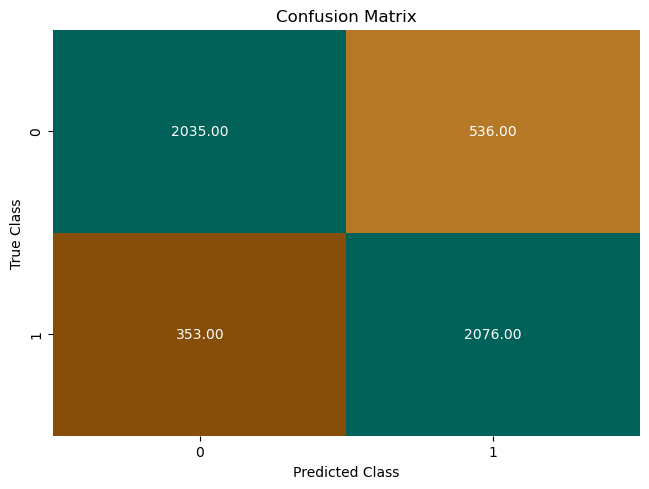

In [51]:
plot_confusion_matrix(test['label'], target_predicted_binary)

# 調用自訂函數輸出指標

提供真實值與預測值計算績效

In [52]:
print_metrics(
    test['label'], 
    target_predicted_binary
)

敏感性/召回率 (Sensitivity or TPR): 85.4672704816797%
特異性 (Specificity or TNR): 79.15208090237262%
精確率 (Precision): 79.47932618683001%
陰性預測值 (Negative Predictive Value): 85.2177554438861%
假陽性率 (False Positive Rate): 20.847919097627383%
假陰性率 (False Negative Rate): 14.532729518320298%
假發現率 (False Discovery Rate): 20.520673813169985%
正確率 (Accuracy): 82.22%


# 標準化文本

從 NLTK 庫獲取停用詞列表

In [53]:
stop = stopwords.words('english')

自訂函數更新停用詞列

In [54]:
def remove_stopwords(stopwords):
    # 特定停用詞
    excluding = ['against', 'not', 'don', 'don\'t', 'ain', 'are', 'aren\'t']

    # 定義需要排除的詞彙，這些詞將不會被視為停用詞
    excluding = [
        'against', 'not', 'don', 'don\'t', 'ain', 'are', 'aren\'t', 'could',
        'couldn\'t','did', 'didn\'t', 'does', 'doesn\'t', 'had', 'hadn\'t',
        'has', 'hasn\'t', 'have', 'haven\'t', 'is', 'isn\'t', 'might',
        'mightn\'t', 'must', 'mustn\'t', 'need', 'needn\'t', 'should',
        'shouldn\'t', 'was', 'wasn\'t', 'were', 'weren\'t', 'won\'t',
        'would', 'wouldn\'t'
    ]

    # 返回移除指定排除詞後的停用詞列表
    return [word for word in stop if word not in excluding]

# 更新後的停用詞列表
stopwords = remove_stopwords(stop)
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

# 詞幹還原

選用英文詞幹化

In [55]:
# SnowballStemmer 是 NLTK 的詞幹還原工具
snow = SnowballStemmer('english')

自定義清理函數

In [56]:
def clean(sent):
    # 將句子轉換為小寫，統一字母大小寫
    sent = sent.lower()
    
    # 使用正則表達式移除多餘的空白字符，將連續的空白轉為單一空格
    sent = re.sub('\s+', ' ', sent)
    
    ### 開始清理過程
    # 移除句首和句尾的空白字符
    sent = sent.strip()
    
    # 使用正則表達式移除 HTML 標籤，例如 `<tag>text</tag>` 會被替換為 `text`
    sent = re.compile('<.*?>').sub('', sent)
    ### 清理結束
    
    # 初始化一個空的列表，存儲經過篩選和詞幹化處理的單詞
    filtered_sentence = []
    
    # 使用 `word_tokenize` 將句子分割成單詞
    for w in word_tokenize(sent):
        # 這裡進行自定義的篩選：檢查該單詞是否符合以下條件：
        # 1. 不是數字
        # 2. 單詞長度大於 2 個字母
        # 3. 不在停用詞列表 `stopwords` 中
        if (not w.isnumeric()) and (len(w) > 2) and (w not in stopwords):  
            # 對符合條件的單詞進行詞幹化處理，並添加到 `filtered_sentence` 列表
            filtered_sentence.append(snow.stem(w))
    
    # 將處理後的單詞列表組合成最終的清理後字串，單詞間以空格分隔
    final_string = " ".join(filtered_sentence) 
    
    # 返回最終清理後的字串
    return final_string

# 觀察一下當前的 df

In [57]:
df

,timestamp,metric_name,value
0,0.0,train:error,0.20855
1,0.0,validation:error,0.23550


為求謹慎，重新進行拆分

In [58]:
train, validate, test = split_data(df)

ValueError: With n_samples=1, test_size=0.5 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
print(train.shape)
print(test.shape)
print(validate.shape)

# 建立管道

設定特徵與目標欄位

In [ ]:
# 設定文本特徵的欄位名稱
text_features = ['text']
# 設定目標欄位名稱
model_target = 'label'

建立轉換管道

In [ ]:
text_processor_0 = Pipeline([(
    # 命名任務
    'text_vect_0', 
    # 進行文本向量化，並使用 clean 函數作為預處理器
    CountVectorizer(
        preprocessor=clean, 
        max_features=500
    )
)])
text_processor_0

定義數據處理的欄位轉換器

In [ ]:
data_preprocessor = ColumnTransformer([(
    # 命名
    'text_pre_0',
    # 指定轉換管道，就是前一個步驟建立的
    text_processor_0, 
    # 要轉換的欄位名稱
    text_features[0]
)])
data_preprocessor

# 輸出之前需要排除可能的錯誤

In [ ]:
import os
import nltk
import zipfile
import urllib.request

# 定義 punkt 資源的下載 URL
punkt_url = "https://github.com/nltk/nltk_data/raw/gh-pages/packages/tokenizers/punkt.zip"

# 定義下載和解壓縮的目標資料夾
nltk_data_path = "/home/ec2-user/SageMaker/nltk_data/tokenizers"
punkt_zip_path = os.path.join(nltk_data_path, "punkt.zip")

# 檢查目標資料夾是否存在，若不存在則建立
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

# 下載 punkt.zip
print("正在下載 punkt.zip...")
urllib.request.urlretrieve(punkt_url, punkt_zip_path)
print("下載完成！")

# 解壓縮 punkt.zip 到指定資料夾
with zipfile.ZipFile(punkt_zip_path, "r") as zip_ref:
    zip_ref.extractall(nltk_data_path)
print("解壓縮完成！")

# 刪除下載的 zip 文件
os.remove(punkt_zip_path)
print("punkt 資源已成功下載並解壓縮到 NLTK 資料夾中！")

# 確保 NLTK 可以找到新的資源
nltk.data.path.append('/home/ec2-user/SageMaker/nltk_data')

import nltk

# 檢查 nltk_data 的目錄路徑
print("目前 NLTK 資源路徑：")
for path in nltk.data.path:
    print(path)

# 嘗試載入 punkt 資源進行檢查
try:
    nltk.data.find("tokenizers/punkt")
    print("punkt 資源配置成功，可以正常載入！")
except LookupError:
    print("punkt 資源未找到，請確認下載和配置路徑。")



輸出

In [ ]:
import re

# 顯示數據集在處理前的形狀（列數和行數）
print(
    '轉換前資料的 shapes：', 
    train.shape, 
    validate.shape, 
    test.shape
)

# 對訓練數據集進行欄位轉換並向量化
train_matrix = data_preprocessor.fit_transform(train)
# 對測試數據集進行欄位轉換並向量化
test_matrix = data_preprocessor.transform(test)
# 對驗證數據集進行欄位轉換並向量化
validate_matrix = data_preprocessor.transform(validate)

# 顯示數據集在處理後的形狀（列數和行數），以確認轉換後的數據形狀變化
print(
    '轉換後資料的 shapes：', 
    train_matrix.shape, 
    validate_matrix.shape, 
    test_matrix.shape
)
